### Based on Algorithm 4 in http://arxiv.org/pdf/1307.1827v7.pdf

In [125]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors.kde import KernelDensity
from sklearn.cross_validation import train_test_split
import pandas as pd
from sklearn.linear_model import Ridge
import seaborn as sns
from __future__ import division
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.covariance import empirical_covariance

In [126]:
from __future__ import division

class Heavy_tail_ridge(Ridge):
    def __init__(self, alpha=1.0, fit_intercept=True, normalize=False,
                 copy_X=True, max_iter=None, tol=1e-3, solver="auto",
                 random_state=None, delta = 0.2, c = 5):
        
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.max_iter = max_iter
        self.tol = tol
        self.solver = solver
        self.random_state = random_state
        self.delta = delta
        self.c = c
        self.models = []
        self.num_of_samples = 0
        self.coef_ = []
        
        
    def fit(self,X,y):
        model_w_vectors = []
        covariance_factor = []
        medians = []
        w = []
        ridge = Ridge(self.alpha, self.fit_intercept, self.normalize,
                 self.copy_X, self.max_iter, self.tol, self.solver,
                 self.random_state)
        self.num_of_samples = np.ceil(self.c * np.log(1/self.delta))
        #self.num_of_samples = 7
        X_samples, y_samples = self._get_samples(X,y,self.num_of_samples)
        sample_size = np.floor(X.shape[0]/self.num_of_samples)
        
        for i in range(len(X_samples)):
            clf = ridge.fit(X_samples[i],y_samples[i])
            self.models.append(clf)
            model_w_vectors.append(self.models[i].coef_)
        
        sigma_cov = []
        for i in range(len(X_samples)):
            sigma_cov.append(empirical_covariance(X_samples[i]))
        #covariance_factor.append((1/(X_samples[i].shape[0])) * (np.vdot(X_samples[i],X_samples[i])))
        for i in range(len(self.models)):
            dist_list = []
            for j in range(len(self.models)):
                if (i == j):
                    continue
                else:
                    dv = model_w_vectors[i] - model_w_vectors[j]
                    distance = np.dot(dv,np.dot((sigma_cov[j] + np.eye(X.shape[1])*self.alpha),dv.T))
                    '''
                    cov = covariance_factor[j] + self.alpha
                    distance = cov * np.vdot(distance_vector,distance_vector)
                    '''
                    dist_list.append(distance)
            medians.append(np.median(dist_list))
                    
        least_median_idx = np.argmin(medians)
        self.coef_ = np.array(model_w_vectors[least_median_idx])
        return self
    
    def predict(self,X):
        res = np.dot(self.coef_,X.T)
        return np.array(res[0])
    
    def _get_samples(self,X,y,num_of_samples):
        X, y = self._shuffle_data(X,y)
        instances = y.shape[0]
        extras = instances % num_of_samples
        if (extras != 0):
            X = X[:instances - extras,:]
            y = y[:instances - extras,:]
        return np.split(X,num_of_samples), np.split(y,num_of_samples)
        
    def _shuffle_data(self,X,y):
        permutation = np.random.permutation(X.shape[0])
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]
        return X_shuffled,y_shuffled    
    
    def score(self, X, y, sample_weight=None):
        r,c = y.shape
        y_pred = self.predict(X)
        y = y.reshape(y_pred.shape)
        J = np.abs(y - y_pred)
        threshold = 0.25
        threshold_matrix = np.true_divide(J,y)
        for i in range(0,r):
            if (threshold_matrix[i] <= 0):
                J[i] = 0
            else:
                J[i] = threshold_matrix[i] - 0
        norm = np.linalg.norm(J)
        loss = np.square(norm) / (2*r)
        return -loss
        

### Experiments with sample data generated

In [127]:
mu, sigma = 0, 1.

In [128]:
#Generating design matrix

X1 = np.random.normal(mu,sigma,300).reshape(100,3)
X2 = np.random.normal(mu,sigma,3000).reshape(1000,3)
X3 = np.random.normal(mu,sigma,6000).reshape(2000,3)
X4 = np.random.normal(mu,sigma,15000).reshape(5000,3)
X5 = np.random.normal(mu,sigma,21000).reshape(7000,3)
X6 = np.random.normal(mu,sigma,54000).reshape(18000,3)
X7 = np.random.normal(mu,sigma,105000).reshape(35000,3)

In [129]:
y2 = np.random.lognormal(mu, sigma, 1000)
y3 = np.random.lognormal(mu, sigma, 2000)
y4 = np.random.lognormal(mu, sigma, 5000)
y5 = np.random.lognormal(mu, sigma, 7000)
y6 = np.random.lognormal(mu, sigma, 18000)
y7 = np.random.lognormal(mu, sigma, 35000)
y1 = np.random.lognormal(mu, sigma, 100)


In [130]:
y1 = np.reshape(y1,(y1.shape[0],1))
y2 = np.reshape(y2,(y2.shape[0],1))
y3 = np.reshape(y3,(y3.shape[0],1))
y4 = np.reshape(y4,(y4.shape[0],1))
y5 = np.reshape(y5,(y5.shape[0],1))
y6 = np.reshape(y6,(y6.shape[0],1))
y7 = np.reshape(y7,(y7.shape[0],1))



In [131]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size =0.3, random_state=5)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size =0.3, random_state=5)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size =0.3, random_state=5)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size =0.3, random_state=5)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size =0.3, random_state=5)
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size =0.3, random_state=5)
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size =0.3, random_state=5)

<IPython.core.display.Javascript object>


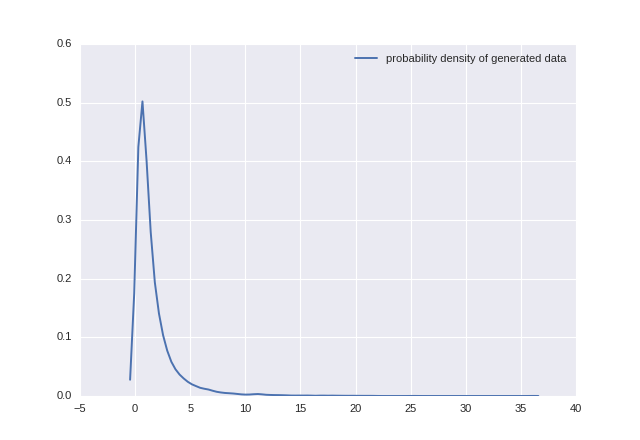

In [132]:
plt.close()
sns.distplot(y7_test,hist=False,label='probability density of generated data')

In [114]:
pipe = Heavy_tail_ridge()

parameters = [{
    'alpha': [0.00001, 0.001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000, 100000 ],
    'delta': [0.1,0.2,0.3,0.4]
}]

grid_search = GridSearchCV(pipe, parameters, n_jobs=-1, verbose=1, cv = 10)

In [133]:
gr1 = grid_search.fit(X1_train,y1_train)
'''
gr2 = grid_search.fit(X2_train,y2_train)
gr3 = grid_search.fit(X3_train,y3_train)
gr4 = grid_search.fit(X4_train,y4_train)
gr5 = grid_search.fit(X5_train,y5_train)
gr6 = grid_search.fit(X6_train,y6_train)
gr7 = grid_search.fit(X7_train,y7_train)
'''


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
[Parallel(n_jobs=-1)]: Done  49 tasks       | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 199 tasks       | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.5s finished


Fitting 10 folds for each of 40 candidates, totalling 400 fits


'\ngr2 = grid_search.fit(X2_train,y2_train)\ngr3 = grid_search.fit(X3_train,y3_train)\ngr4 = grid_search.fit(X4_train,y4_train)\ngr5 = grid_search.fit(X5_train,y5_train)\ngr6 = grid_search.fit(X6_train,y6_train)\ngr7 = grid_search.fit(X7_train,y7_train)\n'

In [134]:
print gr1.best_params_ 
'''
print gr2.best_params_ 
print gr3.best_params_ 
print gr4.best_params_ 
print gr5.best_params_ 
print gr6.best_params_ 
print gr7.best_params_ 
'''

{'alpha': 100, 'delta': 0.4}


'\nprint gr2.best_params_ \nprint gr3.best_params_ \nprint gr4.best_params_ \nprint gr5.best_params_ \nprint gr6.best_params_ \nprint gr7.best_params_ \n'

In [135]:
s1 = gr1.best_score_
'''
s2 = gr2.best_score_
s3 = gr3.best_score_
s4 = gr4.best_score_
s5 = gr5.best_score_
s6 = gr6.best_score_
s7 = gr7.best_score_
'''

'\ns2 = gr2.best_score_\ns3 = gr3.best_score_\ns4 = gr4.best_score_\ns5 = gr5.best_score_\ns6 = gr6.best_score_\ns7 = gr7.best_score_\n'

In [136]:
print s1

-0.498748674239


In [137]:
from sklearn.learning_curve import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(Heavy_tail_ridge(), X7, y7, train_sizes=[500,1000,2000,7000], cv=10)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


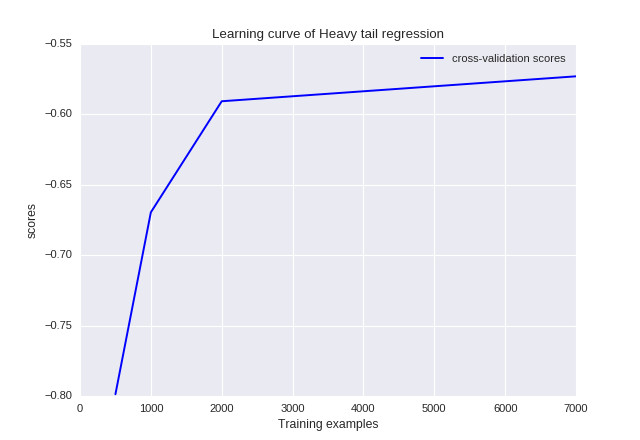

In [138]:
plt.close()
plt.title("Learning curve of Heavy tail regression")
plt.xlabel("Training examples")
plt.ylabel("scores")
plt.plot(train_sizes,valid_scores.mean(axis = 1),'b', label = "cross-validation scores")
plt.legend()

In [139]:
pred = gr1.predict(X2_test)
print gr1.score(X2_test,y2_test)

-0.518330638962


### with Real Salary data

In [140]:
plt.close()
df = pd.read_csv("DesignMatrix.csv")
input = df.as_matrix()
X = input[:,1:-1]
Y = input[:,-1:]



In [164]:


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size =500, random_state=5)
scaler_train = StandardScaler().fit(X_train)
scaler = StandardScaler().fit(y_train)
X_train = scaler_train.transform(X_train)
y_train = scaler.transform(y_train)
X_test = scaler_train.transform(X_test)
y_test = scaler.transform(y_test)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, scale(np.log(Y)), test_size =500, random_state=5)
scaler = StandardScaler().fit(y_train1)
X_train1 = scaler_train.transform(X_train1)
y_train1 = scaler.transform(y_train1)
X_test1 = scaler_train.transform(X_test1)
y_test1 = scaler.transform(y_test1)

In [165]:
print X.shape 
print Y.shape

(3998, 84)
(3998, 1)


In [166]:
gr = grid_search.fit(X_train,y_train)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
[Parallel(n_jobs=-1)]: Done  49 tasks       | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 199 tasks       | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    9.9s finished


Fitting 10 folds for each of 40 candidates, totalling 400 fits


In [167]:
gr1.best_params_

{'alpha': 100000, 'delta': 0.4}

In [168]:
gr1.best_score_

-0.22092951407194994

In [169]:
pred = gr1.predict(X_test)

In [170]:
print gr1.score(X_test,y_test)

-0.233663148349


#### analyzing the coefficients

In [208]:
def printWstats(clf, dm, threshold= 1e-04, threshold2=1e-05):
    # threshold =0.1
    # threshold2 =0.01
    coef1 = np.copy(clf.best_estimator_.coef_)
    coef1 = coef1.reshape(coef1.shape[1],)
    for i in range(0,len(coef1)):
        if abs(coef1[i]) < threshold:
            coef1[i] = 0

    cols = list(dm.columns.values)

    print "Tier 1"
    for i in range(0,len(coef1)):
        if coef1[i] > 0:
            print "Pos",",", i+1,",", cols[i],",", coef1[i]
    for i in range(0,len(coef1)):
        if coef1[i] < 0:
            print "Neg",",", i+1,",", cols[i],",", coef1[i]

    print "Tier 2"
    coef2 = np.copy(clf.best_estimator_.coef_)
    coef2 = coef2.reshape(coef2.shape[1],)
    for i in range(0,len(coef2)):
        if not (abs(coef2[i]) <= threshold and abs(coef2[i] >= threshold2)):
            coef2[i] = 0
    for i in range(0,len(coef2)):
        if coef2[i] > 0:
            print "Pos",",", i+1,",", cols[i],",", coef2[i]
    for i in range(0,len(coef2)):
        if coef2[i] < 0:
            print "Neg",",", i+1,",", cols[i],",", coef2[i]

In [209]:
printWstats(gr1, df)

Tier 1
Pos , 4 , cbse , 0.000260113320301
Pos , 5 , icse , 0.000649203129669
Pos , 9 , icse.1 , 0.000660768526553
Pos , 11 , state.1 , 0.000454624683998
Pos , 17 , mechanical , 0.000179102094338
Pos , 25 , production , 0.000208204032763
Pos , 26 , information , 0.00025913810852
Pos , 27 , telecommunications , 0.000175163218637
Pos , 28 , technology , 0.000282350576976
Pos , 35 , Assam , 0.000260097572541
Pos , 36 , Bihar , 0.000154493075379
Pos , 42 , Himachal Pradesh , 0.000183052222485
Pos , 43 , Jammu and Kashmir , 0.000227958516555
Pos , 44 , Jharkhand , 0.000207745949318
Pos , 46 , Kerala , 0.000105617036912
Pos , 52 , Rajasthan , 0.000132815343149
Pos , 54 , Tamil Nadu , 0.000219181717131
Pos , 57 , Uttar Pradesh , 0.000279797499078
Pos , 60 , myDOB , 0.000227102298134
Pos , 64 , 12graduation , 0.000685477850444
Pos , 65 , 10percentage , 0.000823646279
Pos , 67 , CollegeTier , 0.000597315443336
Pos , 68 , collegeGPA , 0.000118511227011
Pos , 69 , CollegeCityTier , 0.0004972488217

In [171]:
gr1.best_estimator_.coef_.reshape(84,)

array([ -5.45394590e-04,   5.45394590e-04,   2.10169222e-04,
         2.65402480e-04,   5.07233104e-04,  -6.21383057e-04,
         2.21444573e-04,   1.13072760e-04,   5.04281940e-04,
        -5.39118007e-04,   3.26933942e-04,   1.93914214e-35,
        -1.93128441e-04,  -2.66979252e-04,  -2.86974794e-04,
         3.75596567e-04,  -1.58597061e-04,  -5.17837326e-04,
        -1.90648669e-04,   1.08686129e-04,   3.36848798e-05,
        -1.17934078e-04,  -2.66374055e-04,   3.09059761e-04,
         3.06216676e-05,  -1.87964941e-05,   3.44355763e-05,
        -2.09923309e-05,   2.94719171e-04,   6.24551433e-04,
         1.85038382e-04,  -1.41895783e-04,  -8.63315124e-05,
         1.98275419e-04,  -1.48961518e-04,  -5.15132301e-05,
         3.28785201e-04,   0.00000000e+00,   8.69655240e-04,
         1.58585114e-04,   6.14469978e-05,   2.25790616e-04,
         1.49756081e-05,   4.71166505e-04,  -5.75357144e-05,
         4.35521619e-05,   2.59678430e-04,  -3.35736730e-36,
         8.93170031e-05,

### MOM with Log salary as the response variable

In [172]:
gr_1 = grid_search.fit(X_train,y_train1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
[Parallel(n_jobs=-1)]: Done  49 tasks       | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 199 tasks       | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    9.5s finished


Fitting 10 folds for each of 40 candidates, totalling 400 fits


In [173]:
gr_1.best_score_

-0.28236684483727298

In [174]:
print gr_1.score(X_test1,y_test1)

-0.288298122141


### Comparison of Lasso, Ridge, MOM(with normal response), MOM

<IPython.core.display.Javascript object>


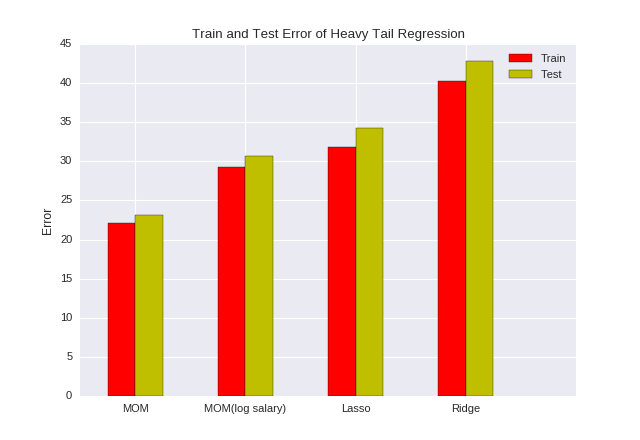

In [159]:
import numpy as np
import matplotlib.pyplot as plt

N = 4
train_error = (22.12, 28.23, 31.86, 40.23)

ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, train_error, width, color='r')

test_error = (23.16, 30.73, 34.27, 42.83)
rects2 = ax.bar(ind+width, test_error, width, color='y')

# add some
ax.set_ylabel('Error')
plt.xlim(-width,len(ind)+width)
ax.set_title('Train and Test Error of Heavy Tail Regression')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('MOM', 'MOM(log salary)', 'Lasso', 'Ridge') )

ax.legend( (rects1[0], rects2[0]), ('Train', 'Test')) 

plt.show()